<a href="https://colab.research.google.com/github/mantoan-thi/Machine_learning_na_B3/blob/main/ARIMA_Previs%C3%A3o_com_s%C3%A9ries_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [6]:
#importando bibliotecas essenciais
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
yf.pdr_override()
%matplotlib inline

In [8]:
dados = web.get_data_yahoo('ITUB4.SA','2018-01-01','2021-05-14')
dados.sort_values('Date', inplace=True)
df = dados['Adj Close']
df = pd.DataFrame(df)
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2018-01-02,25.130365
2018-01-03,25.302181
2018-01-04,25.829071
2018-01-05,25.903526
2018-01-08,25.817610


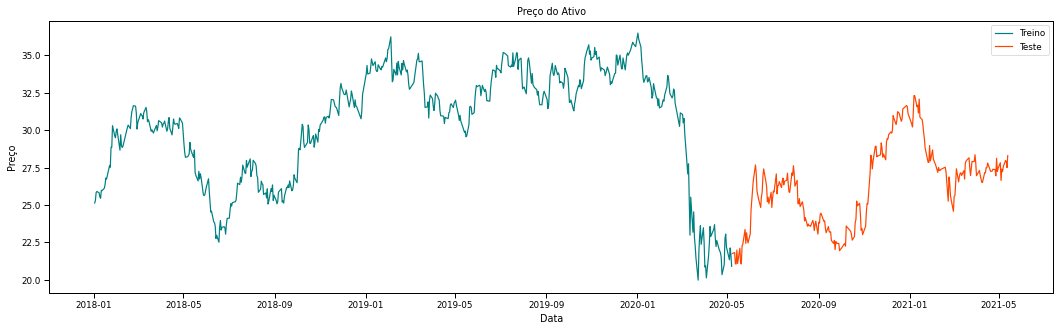

In [9]:
dias = 250
treino = df.iloc[:-dias,0:1].copy()
teste = df.iloc[-dias:,0:1].copy()
plt.figure(figsize=(18,5))
plt.title('Preço do Ativo')
plt.plot(treino['Adj Close'], color='teal')
plt.plot(teste['Adj Close'], color='orangered')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()


In [10]:
# Teste de estacionariedade e verificando Correlações
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def checar_estacionariedade(y, lags_plots=48, figsize=(22,8)):
    "Use Series como parâmetro"
    
    # Criando plots do DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, color='teal')
    ax1.set_title('Série de Preços')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    ax4.set_title('Distribuição dos Preços')

    plt.tight_layout()
    
    print('Resultados do teste de Dickey-Fuller:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Teste Statistico','Valor-P','Lags Usados','Números de Observações'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Valores Críticos (%s)"%key] = value.round(4)
        
    print(adftest)

Resultados do teste de Dickey-Fuller:
Teste Statistico           -1.2565
Valor-P                     0.6488
Lags Usados                 7.0000
Números de Observações    569.0000
Valores Críticos (1%)      -3.4419
Valores Críticos (5%)      -2.8666
Valores Críticos (10%)     -2.5695
dtype: float64


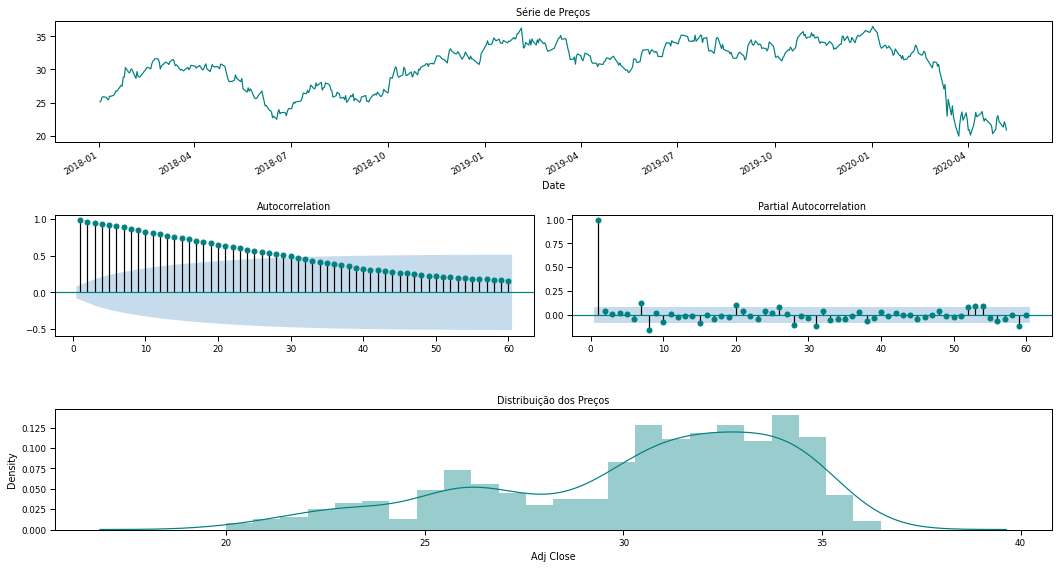

In [11]:
# Para verificar se a série de treino é estacionária, iremos usar o valor P de 5% como base para estacionariedade, 
# caso o valor P do teste seja inferior a 5% podemos considerar que a série é estacionária:
checar_estacionariedade(treino['Adj Close'], lags_plots=60)

Resultados do teste de Dickey-Fuller:
Teste Statistico           -8.5523
Valor-P                     0.0000
Lags Usados                 6.0000
Números de Observações    569.0000
Valores Críticos (1%)      -3.4419
Valores Críticos (5%)      -2.8666
Valores Críticos (10%)     -2.5695
dtype: float64


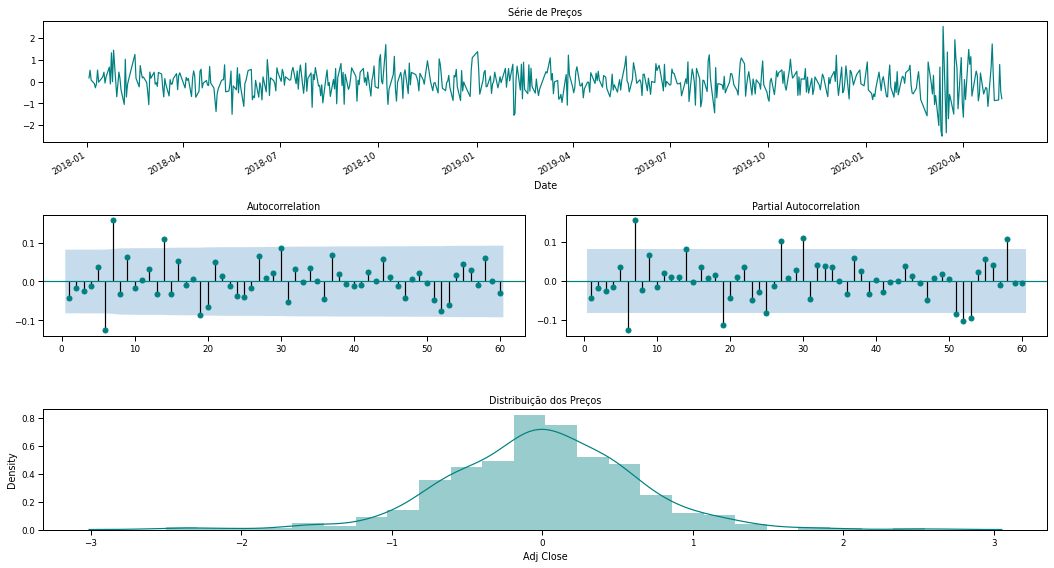

In [12]:
'''Analisando o gráfico da série de preços, nota-se que ele tem uma leve tendência de alta, 
   observando os dados estatísticos a série ficou com o valor P de 8,7%, a distribuição dos 
   dados não segue uma normalidade gaussiana, e as características da autocorrelação 
   mostram correlações significativas em todos os lags, isso é sinal de uma série com
   tendência e que pode-se fazer ao menos uma diferenciação.

   Assim, essa série não satisfaz os critérios estabelecidos para ser considerada estacionária.'''
# Vou fazer a primeira diferenciação para retirar a tendência e ficar somente as movimentações dia-a-dia:
checar_estacionariedade(treino['Adj Close'].diff().dropna(), lags_plots=60)

In [13]:
# Treinando o modelo
modelo = ARIMA(treino['Adj Close'], order=(15,1,0)).fit()
pred_treino = modelo.predict()

In [14]:
# Base de previsão com diferenciação
pred_treino[:5]

Date
2018-01-03   -0.006616
2018-01-04   -0.014153
2018-01-05   -0.032937
2018-01-08   -0.025383
2018-01-09   -0.021340
dtype: float64

In [15]:
# Voltando para a base de preços em R$/m3
pred_treino[0] += treino.iloc[0,0]
pred_treino = np.cumsum(pred_treino)
pred_treino.head()

Date
2018-01-03    25.123749
2018-01-04    25.109596
2018-01-05    25.076660
2018-01-08    25.051277
2018-01-09    25.029937
dtype: float64

In [16]:
treino['Pred Close'] = pred_treino
treino.dropna(inplace=True)
treino.head()

,Adj Close,Pred Close
Date,,
2018-01-03,25.302181,25.123749
2018-01-04,25.829071,25.109596
2018-01-05,25.903526,25.076660
2018-01-08,25.817610,25.051277
2018-01-09,25.536989,25.029937


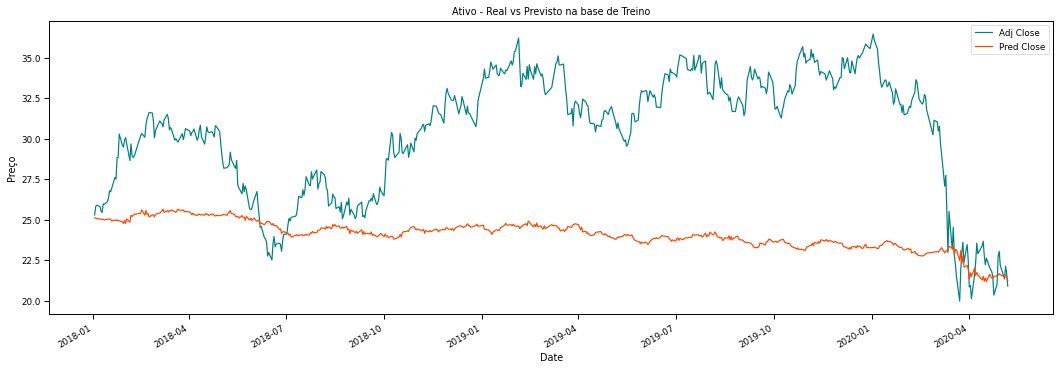

In [17]:
# Plotando o gráfico
treino.plot(figsize=(18,6), 
            title='Ativo - Real vs Previsto na base de Treino',
           color=['Teal','orangered'])
plt.ylabel('Preço')
plt.show()

In [ ]:
#Medindo o erro do treino pela métrica Root Mean Squared Error
from sklearn.metrics import mean_squared_error
erro = sqrt(mean_squared_error(treino['Adj Close'], treino['Pred Close']))
print(f'O RMSE foi de R$ {round(erro,4)}/sc')

O RMSE foi de R$ 8.1253/sc


In [ ]:
def prever_n_per(treino, teste, passos):
    
    # Adicionando a série com diferenciação para projetar previsões
    diff_treino = treino.diff().dropna().values
    hist = [x for x in diff_treino]

    diff_teste = teste.diff().dropna().values
    diff_teste = [x for x in diff_teste]

    # Adicionando primeira diferenciação no teste que ficou entre o treino e teste
    prim_diff = teste[0] - treino[-1]
    diff_teste.insert(0, prim_diff)
    
    prev = []

    for i in range(0,len(teste),passos):
        for j in range(passos):
    
            yhat = const + (l1 * hist[-1]) + (l2 * hist[-2]) + (l3 * hist[-3])
            prev.append(yhat)
            # usando a previsão atual como base para novas previsões
            hist.append(yhat)
        obs = diff_teste[i:i+passos]
        hist = list(np.append(hist,obs))
    return prev

In [ ]:
# Testando a função
steps = 5
prev = prever_n_per(treino['Adj Close'], teste['Adj Close'], passos=steps)
print('Previsões antes de reverter os preços: ')
print(prev[:5])

Previsões antes de reverter os preços: 
[0.0023486107721612318, 0.018077853646868612, -0.026032604150942024, 0.004496148795988787, 0.0035944942952410397]


In [ ]:
def inverter_diff(treino, teste, previsão, passos):
    '''
    Usando o último dia da base de treino, após isso, usa o último valor previsto como base sucessivamente.
    
    A cada passo, volta a usar o primeiro valor da base de teste que se tornou real.
    '''
    treino = [x for x in treino]
    teste = [x for x in teste]
    prev_inv = []
    
    for i in range(0,len(teste), passos): 
        inverter = previsão[i] + treino[-1]
        prev_inv.append(inverter)
        
        for j in range(passos-1):
            inverter += previsão[i+j+1]
            prev_inv.append(inverter)
        treino = np.append(treino, teste[i:i+passos])
    return prev_inv

In [ ]:
# Adicionando a previsão na base de testes para comparar posteriormente
teste['Previsão 5D'] = inverter_diff(treino['Adj Close'],
                                    teste['Adj Close'],
                                    prev, passos=steps)

In [ ]:
def plotar_comparativo(orig, prev, passos, titulo='', figsize=(18,8)):
    plt.figure(figsize=figsize)
    
    orig = np.array(orig)
    prev = np.array(prev)
    plt.plot(orig, label='Real', color='teal')
    
    for i in range(0,len(orig), passos):
        eixo_x = [x for x in range(i,i+passos)]
        plt.plot(eixo_x, prev[i:i+passos], color='orangered')
    
    plt.title(titulo)
    plt.ylabel('Preços')
    plt.show()


<IPython.core.display.Javascript object>


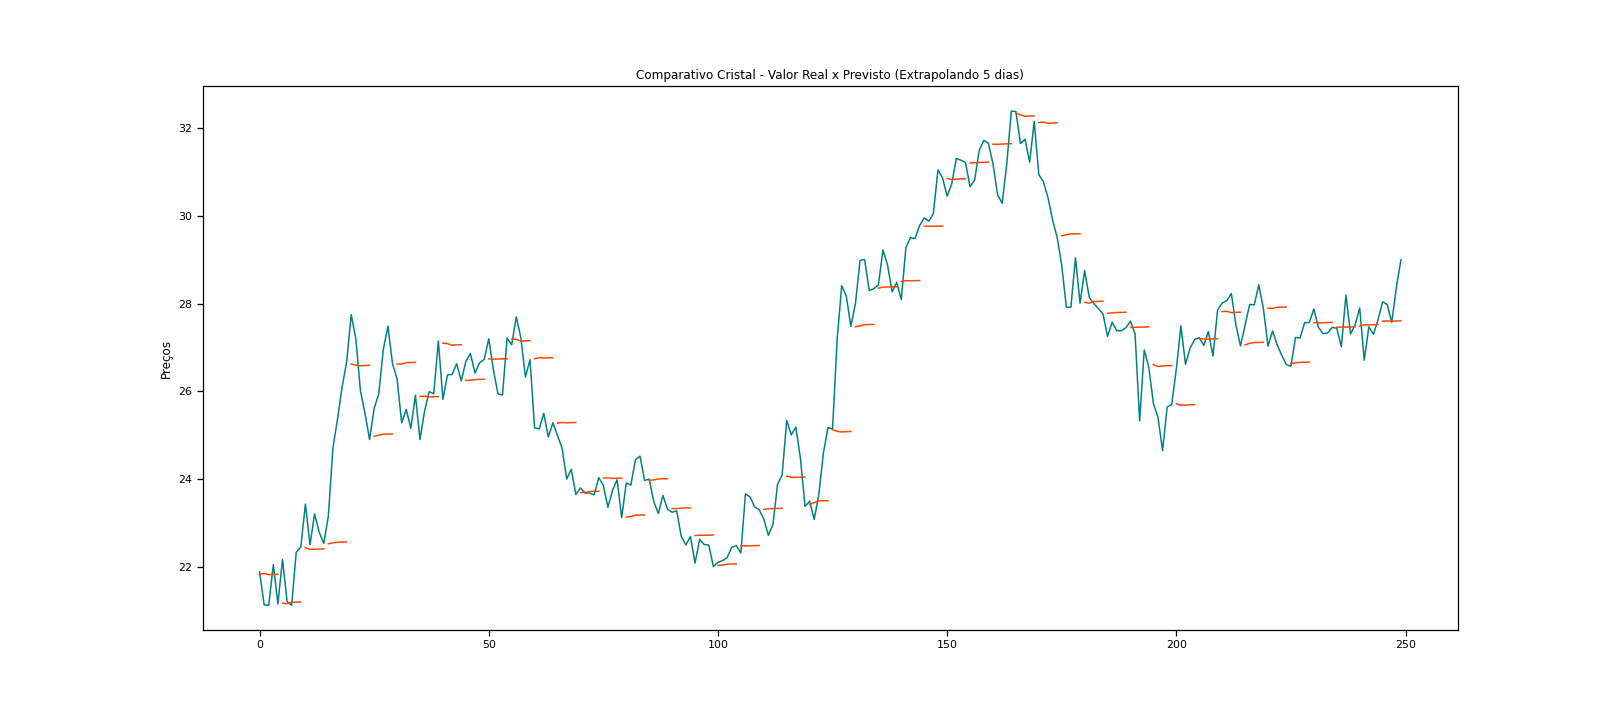

In [ ]:
plotar_comparativo(teste['Adj Close'], teste['Previsão 5D'], passos=steps, 
                   titulo='Comparativo Cristal - Valor Real x Previsto (Extrapolando 5 dias)')

In [ ]:
def erro_n_passos(orig, prev, passos, plot=True):
    # Calculando o RMSE de cada linha
    erro = ((np.array(orig) - np.array(prev))**2)**(1/2)
    
    # Mudando o formato para ficar: (erros/exemplos, passos)
    erro = erro.reshape(int(len(erro)/passos), passos)
    
    # Fazendo a média do erro para cada passo
    media = erro.mean(axis=0)
    
    # Plotando o gráfico de erro
    if plot:
        indice = np.arange(0,passos)
        plt.figure(figsize=(12,4))
        plt.plot(media, 'o-', color='teal', markersize=8)
        plt.title('Erro Médio para Cada Passo', fontsize=15)
        plt.xlabel('Passos', fontsize=15)
        plt.ylabel('Erro', fontsize=15)
        for x,y in zip(indice, media):
            label = "{:.4f}".format(y)
            plt.annotate(label, (x, y), xytext=(x-0.1, y+.075), fontsize=12)
        plt.xticks(np.arange(passos), [x for x in range(1,passos+1)])
        plt.yticks([x for x in np.linspace(min(media)-0.2, max(media)+0.2, 10)])
        plt.grid(axis='y')
        plt.show()
    print(f'O RMSE para cada passo ficou assim: \n{media}')

<IPython.core.display.Javascript object>


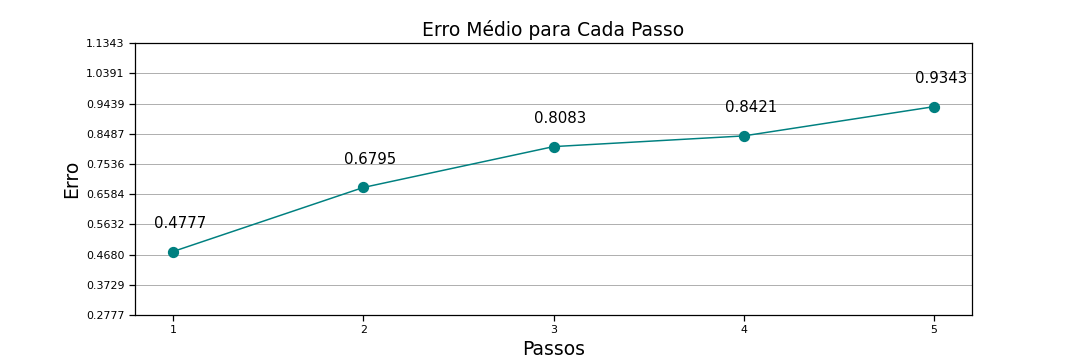

O RMSE para cada passo ficou assim: 
[0.47768143 0.67952881 0.80833165 0.84208168 0.93425652]


In [ ]:
erro_passo = erro_n_passos(teste['Adj Close'], teste['Previsão 5D'], steps)
erro_passo

<IPython.core.display.Javascript object>


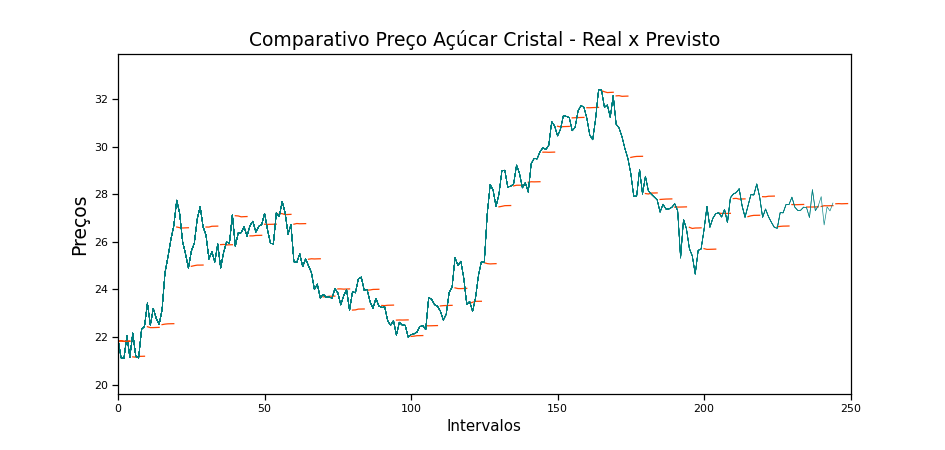

In [ ]:


passos = 5
eixo_x_prev = []
eixo_x_real = [x for x in range(len(teste))]
prev = []
pred = np.array([x for x in teste['Previsão 5D']])
base = [x for x in teste['Adj Close']]

for i in range(0,len(teste), passos):
    eixo_x_prev.append([x for x in range(i,i+passos)])
    prev.append([x for x in pred[i:i+passos]])

# Criando a base dos gráficos
fig = plt.figure(figsize=(10.5,5))
plt.axis([0, len(base), min(base)-2.5,max(base)+2.5])

def animate(i):
    
    plt.plot(eixo_x_prev[i], prev[i], c='orangered', lw=1)
    plt.plot(eixo_x_real[:i*passos], base[:i*passos], c='teal', lw=0.50)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Preços', fontsize=15)
plt.title('Comparativo Preço Açúcar Cristal - Real x Previsto', fontsize=15)
plt.axis([0, len(base), min(base)-1.5 ,max(base)+1.5])
    

ani = FuncAnimation(fig, animate, frames=50, interval=250)
#ani.save('comparativo.htm')
plt.show()